# FOIL Project 4: Overcoming catastrophic forgetting in neural networks.

[This paper](https://arxiv.org/pdf/1612.00796.pdf), by James Kirkpatrick et al., studies the setting of continual learning, where an agent learns multiple tasks sequentially, i.e., accumulating knowledge for a new task/experience without having access to data from past tasks. In this setting, the phenomenon of catastrophic forgetting arises; the performance of the agent on past experiences significantly diminishes upon learning new tasks. The paper proposes the use of a regularization term to combat this problem. We suggest steering from the reinforcement learning experience and, instead, focus on supervised learning. Reproduce the results of Figure 2 (subfigures A + B) on the following datasets: PermutedMNIST (as in the paper) as well as RotatedMNIST (ten tasks of rotating MNIST, where task i is produced by a fixed rotation of 10(i − 1) degrees). Compare the results of the proposed regularization with naive L2 regularization and no regularization.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from typing import Dict, Optional
import os

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Load the data:

Create three tasks of permuted MNIST

In [18]:
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

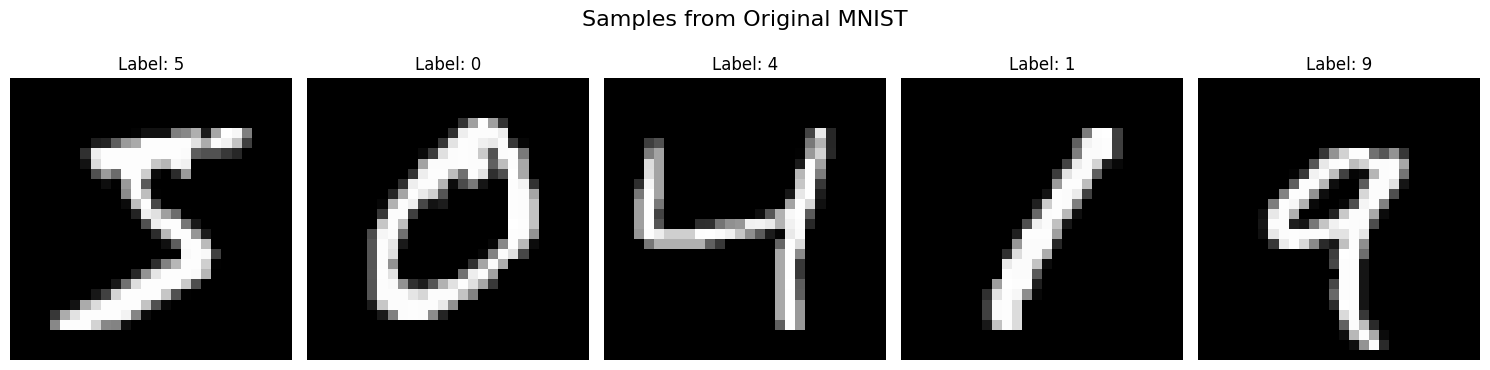

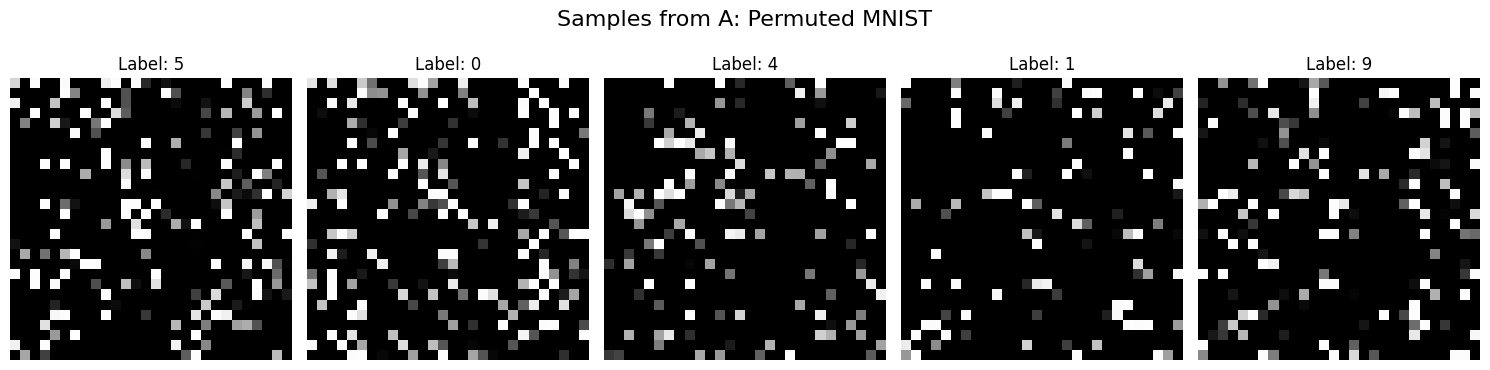

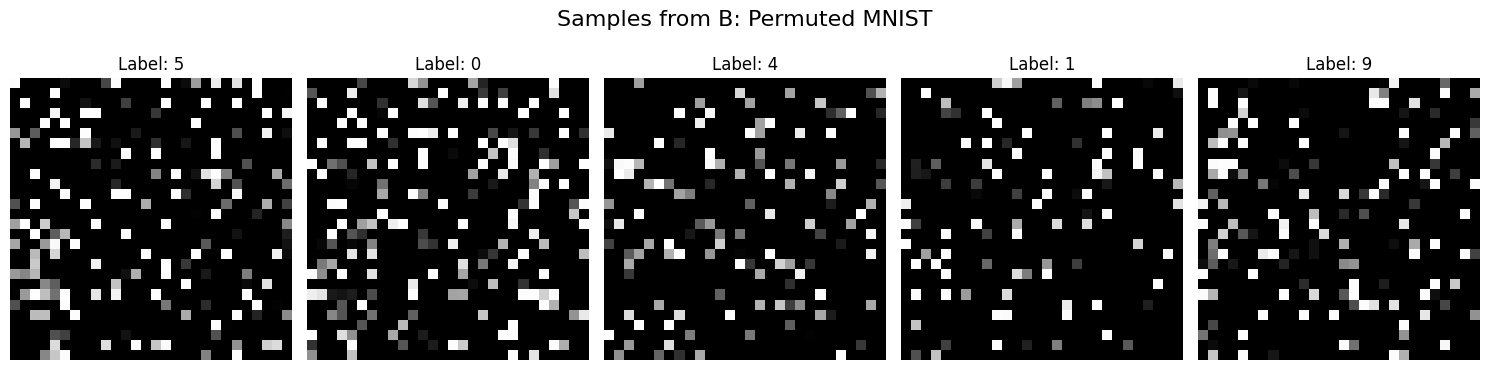

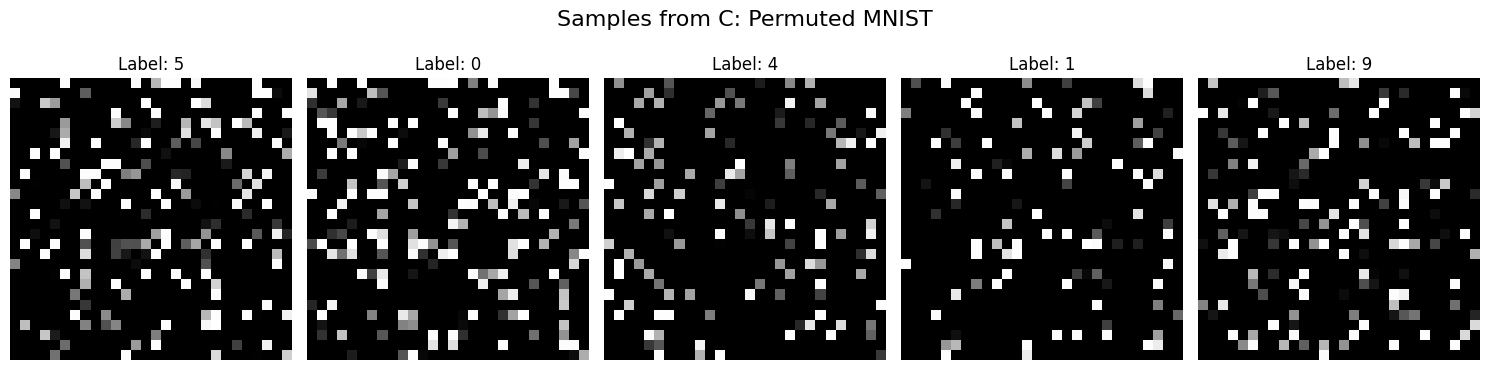

In [19]:
Task = namedtuple("Task", ["name", "train", "test"])

def create_permuted_mnist(rng):
    """
    Create a permuted MNIST dataset for a given task ID using a shared random number generator.
    """
    perm = torch.tensor(rng.permutation(28 * 28), dtype=torch.long)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1)[perm].view(1, 28, 28))
    ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    return train_dataset, test_dataset

# Fix a single seed
seed = 42
rng = np.random.RandomState(seed)

# Create permuted tasks
Original_MNIST = Task(name="Original MNIST", train=mnist_train, test=mnist_test)

def create_permuted_tasks(rng, num_tasks):
    perm_tasks = []
    for i in range(num_tasks):
        train, test = create_permuted_mnist(rng)
        perm_tasks.append(Task(name=f"{chr(i+65)}: Permuted MNIST", train=train, test=test))
    return perm_tasks

perm_tasks = create_permuted_tasks(rng, 3)

for task in [Original_MNIST] + perm_tasks:
    loader = DataLoader(task.train, batch_size=5, shuffle=False)
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    for j in range(5):
        axes[j].imshow(images[j].squeeze(0), cmap="gray")
        axes[j].set_title(f"Label: {labels[j].item()}")
        axes[j].axis("off")
    
    fig.suptitle(f"Samples from {task.name}", fontsize=16)
    fig.tight_layout()

    plt.show()


Create rotated MNIST datasets:

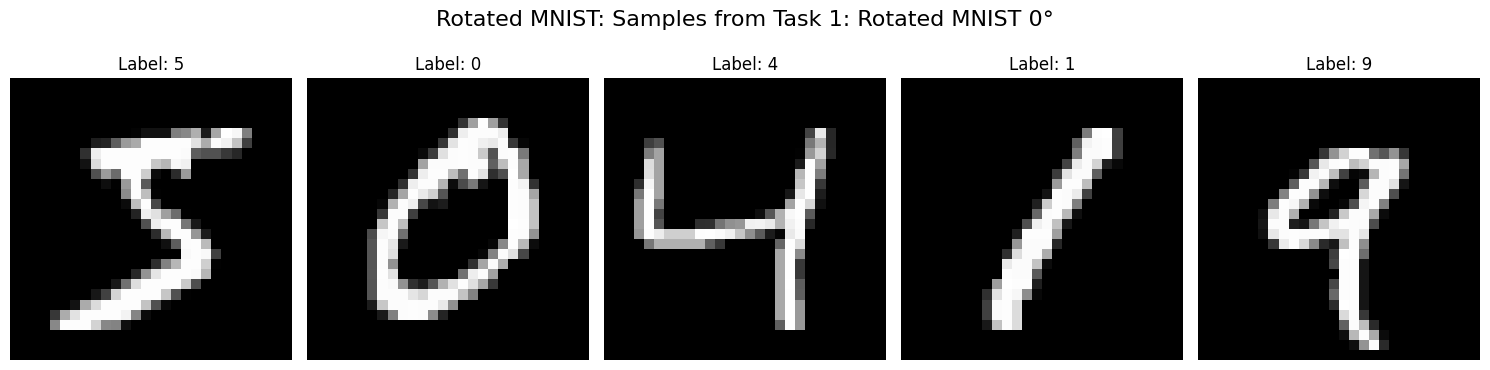

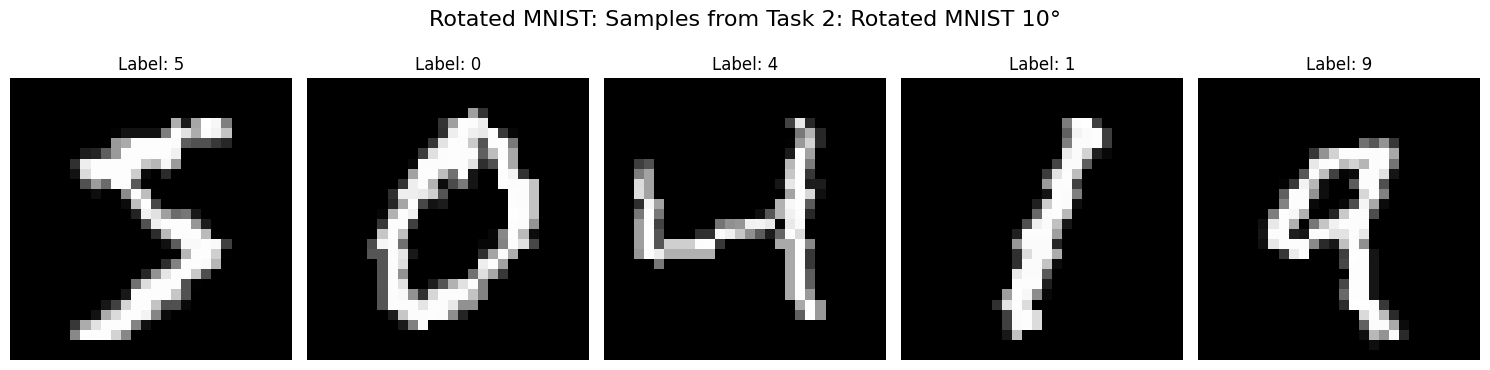

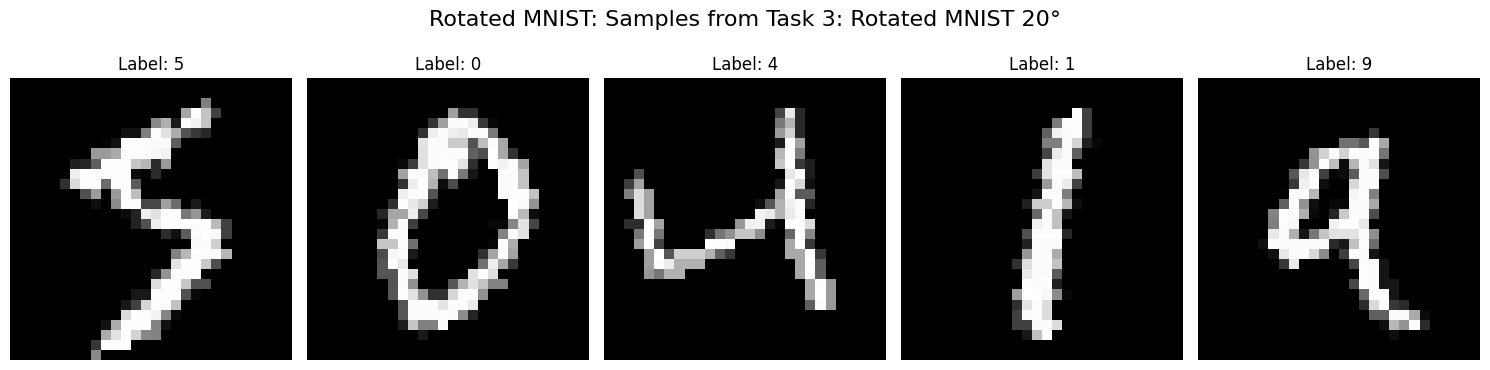

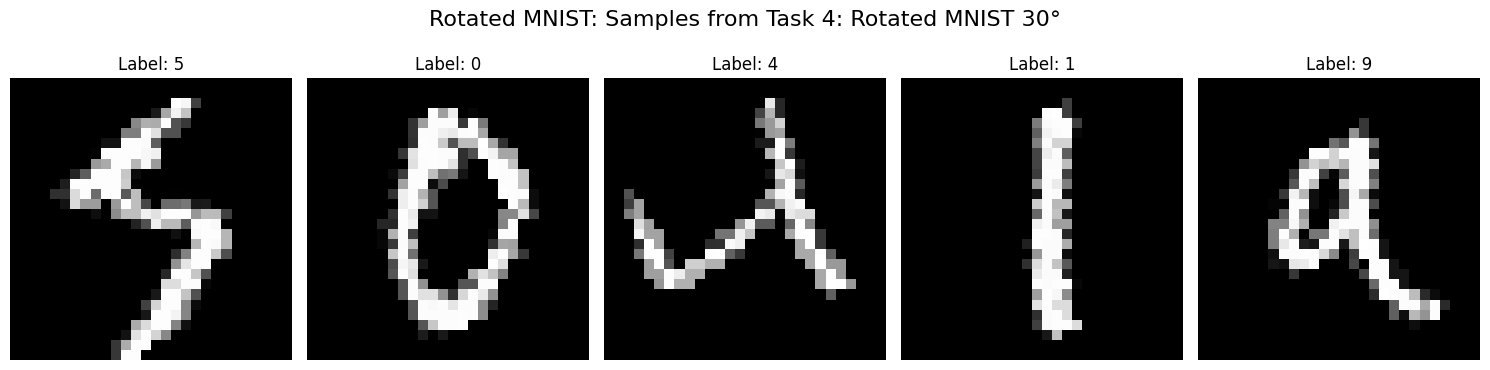

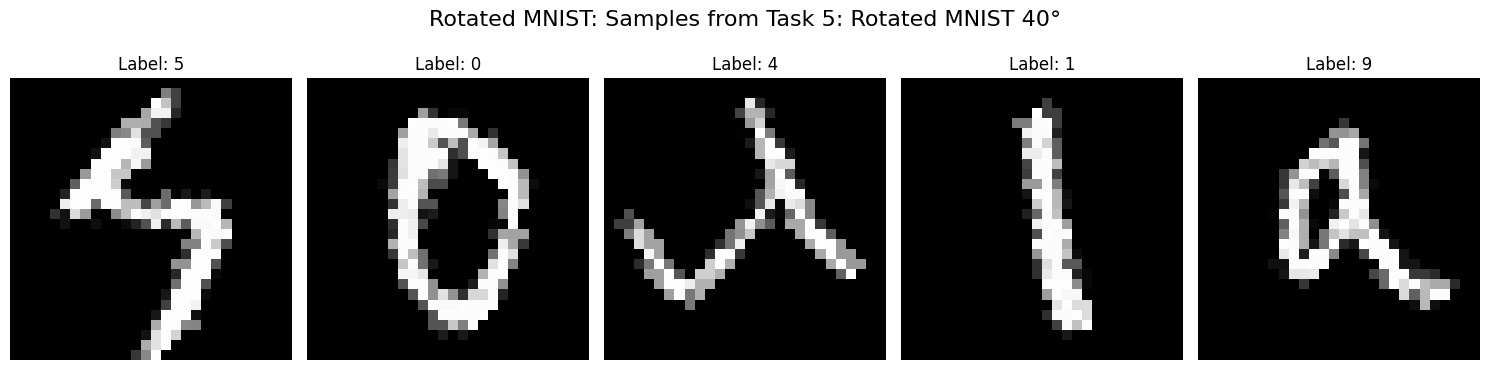

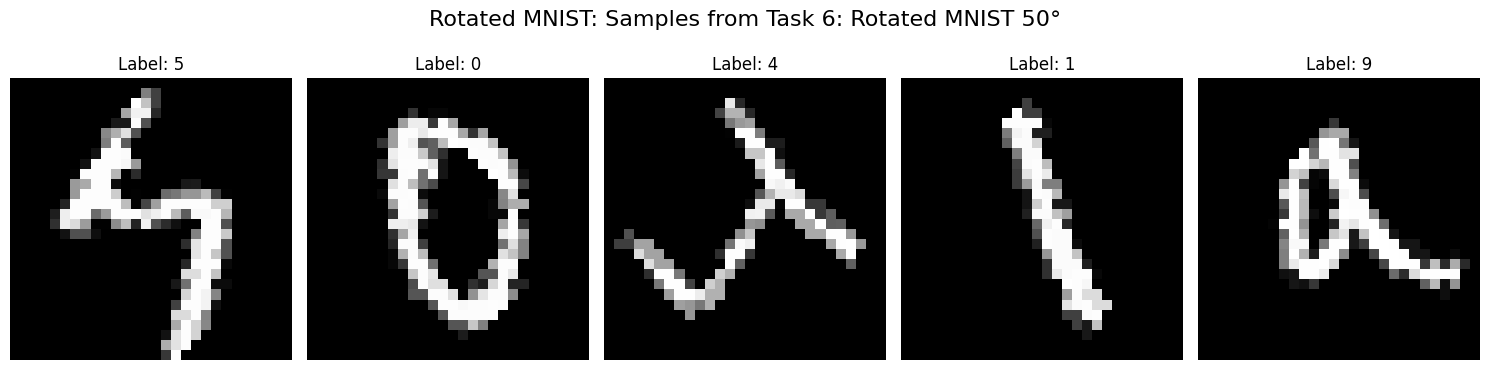

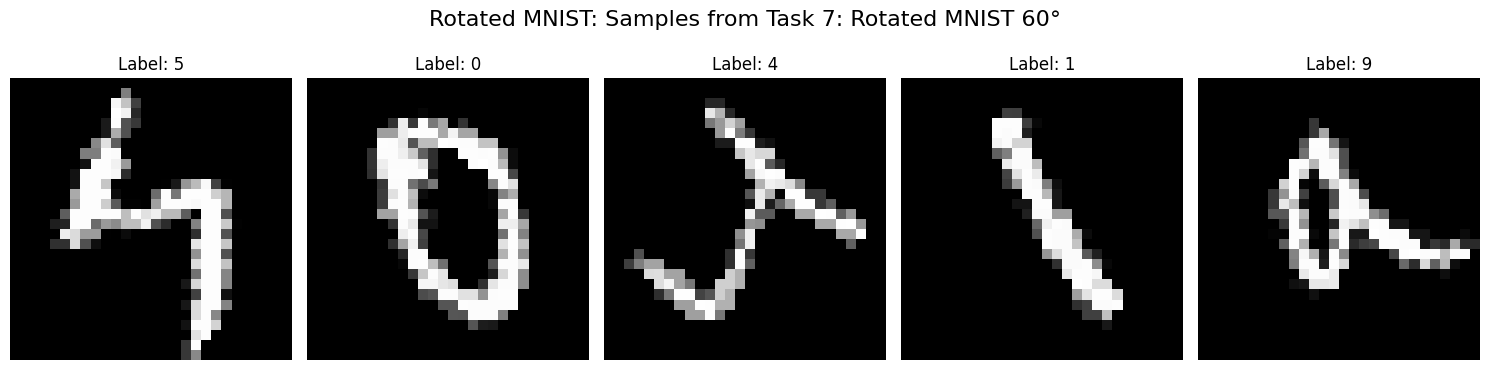

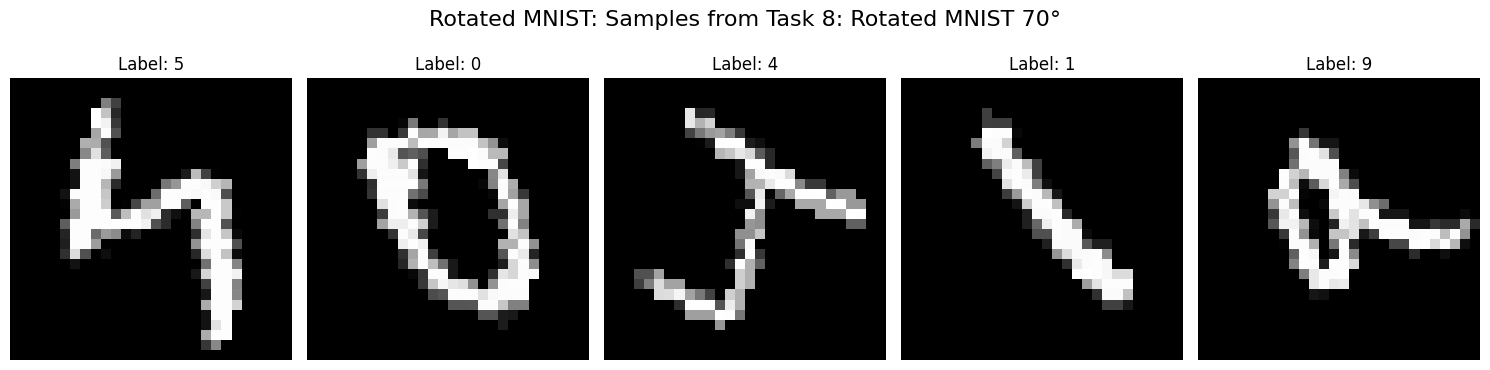

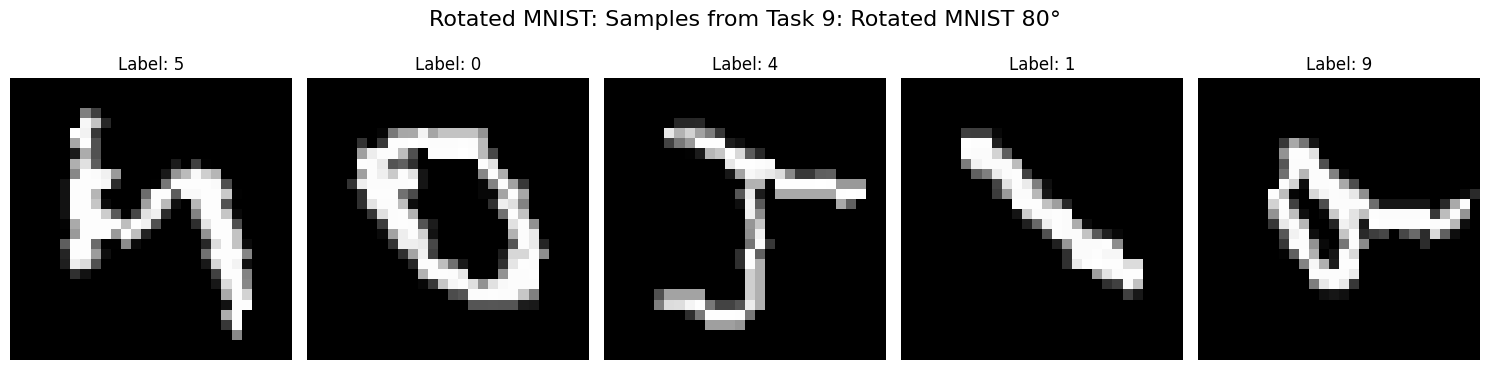

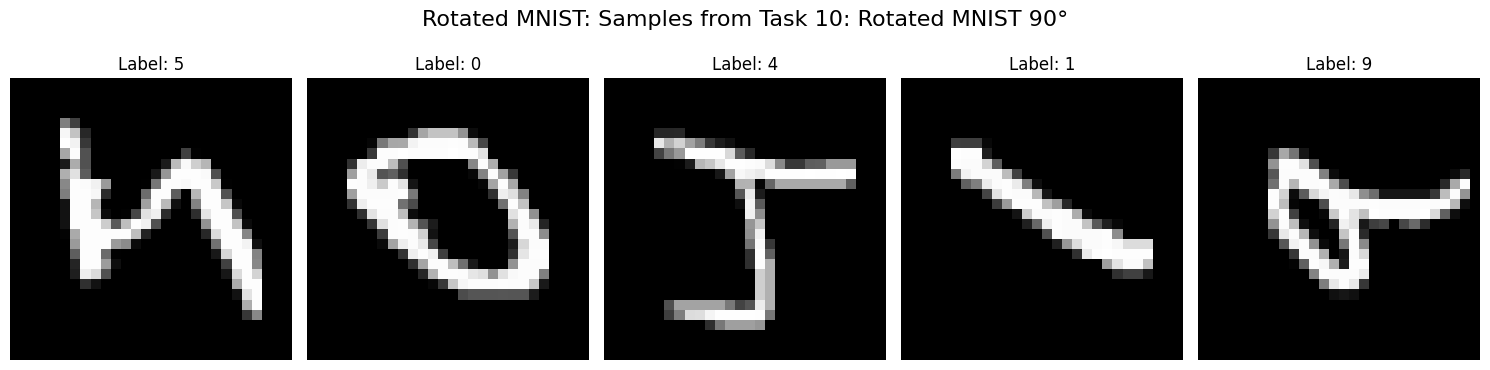

In [20]:
def create_rotated_mnist(task_id, base_angle=0):
    rotation_angle = base_angle + 10 * (task_id - 1)  # Fixed rotation for task
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: transforms.functional.rotate(x, angle=rotation_angle))
    ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    return train_dataset, test_dataset

# Generate ten tasks of Rotated MNIST
def create_rotated_tasks(num_tasks):
    rot_tasks = []
    for i in range(1, num_tasks + 1):
        train, test = create_rotated_mnist(i)
        rot_tasks.append(Task(name=f"Task {i}: Rotated MNIST {10 * (i - 1)}°", train=train, test=test))
    return rot_tasks

rot_tasks = create_rotated_tasks(10)

# Visualize samples from each task
for task in rot_tasks:
    loader = DataLoader(task.train, batch_size=5, shuffle=False)
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    for j in range(5):
        axes[j].imshow(images[j].squeeze(0), cmap="gray")
        axes[j].set_title(f"Label: {labels[j].item()}")
        axes[j].axis("off")
    
    fig.suptitle(f"Rotated MNIST: Samples from {task.name}", fontsize=16)
    fig.tight_layout()

    plt.show()

## Add the model

The paper proposes a fully connected network (FCN)

They don't mention the size of the validation set, should we just take 20% ?

In [21]:
class Fcn(nn.Module):
    def __init__(self, num_hidden_layers, hidden_size, dropout=False):
        super(Fcn, self).__init__()
        layers = [torch.nn.Flatten()]  # Flatten the input tensor for FCN
        
        # Input to first hidden layer
        layers.append(nn.Linear(28 * 28, hidden_size))
        layers.append(nn.ReLU())
        if dropout:
            layers.append(nn.Dropout(p=0.2))
        
        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(p=0.5))
        
        # Output layer (mapping to 10 classes for MNIST)
        layers.append(nn.Linear(hidden_size, 10))
        
        self.model = nn.Sequential(*layers)
        
        # Initialize for EWC
        self.fisher_info = {}
        self.old_params = {}
        self.ewc_lambda = 0.0
        self.ewc_loss = 0.0

    def forward(self, x):
        return self.model(x)

    def save_parameters(self):
        """Save current model parameters for future use."""
        print("Saving model parameters (task 1)")
        self.old_params = {
            n: p.data.clone().to(device)
            for n, p in self.named_parameters()
            if p.requires_grad
        }
        
    def compute_fisher(self, dataset):
        """Compute Fisher information matrix for EWC."""
        fisher = {
            n: torch.zeros_like(p, device=p.device)
            for n, p in self.named_parameters()
            if p.requires_grad
        }

        self.eval()
        device = next(self.parameters()).device
        loader = DataLoader(dataset, batch_size=32, shuffle=True)

        for batch_embeddings, batch_labels in loader:
            batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

            self.zero_grad()
            outputs = self(batch_embeddings)
            probs = F.softmax(outputs, dim=1)
            log_probs = F.log_softmax(outputs, dim=1)

            # Sample labels from the output distribution
            sampled_labels = torch.multinomial(probs, 1).squeeze().to(device)

            # Compute loss with sampled labels
            loss = F.nll_loss(log_probs, sampled_labels)

            # Compute gradients
            loss.backward()

            # Accumulate Fisher information
            for n, p in self.named_parameters():
                if p.grad is not None:
                    fisher[n] += (p.grad.data ** 2) / len(loader)

        return fisher

    def consolidate_ewc(self, dataset: torch.utils.data.Dataset, ewc_lambda: float):
        """Update Fisher information and old parameters after training a task."""
        print("Consolidating EWC...")

        device = next(self.parameters()).device
        new_fisher_info = self.compute_fisher(dataset)
        for n, p in new_fisher_info.items():
            p = p.to(device)
            if n in self.fisher_info:
                self.fisher_info[n] = self.fisher_info[n].to(device) + p
            else:
                self.fisher_info[n] = p.clone()
        """ self.old_params = {
            n: p.data.clone()
            for n, p in self.named_parameters()
            if p.requires_grad
        } """
        self.save_parameters()
        self.ewc_lambda = ewc_lambda


    def _ewc_loss(self, batch_size=None):
        """
        Compute EWC loss with detailed statistics tracking.
        Returns the total EWC loss and stores component-wise statistics.
        """
        total_loss = 0
        component_losses = {}
        
        # Compute loss for each parameter
        for n, p in self.named_parameters():
            if p.requires_grad and n in self.fisher_info:
                # Component-wise squared distance weighted by Fisher information
                squared_dist = (p - self.old_params[n]) ** 2
                fisher_weighted_dist = self.fisher_info[n] * squared_dist
                component_loss = fisher_weighted_dist.sum()
                
                # Store statistics for this parameter
                component_losses[n] = {
                    'loss': component_loss.item(),
                    'mean_squared_dist': squared_dist.mean().item(),
                    'mean_fisher': self.fisher_info[n].mean().item(),
                    'max_fisher': self.fisher_info[n].max().item()
                }
                
                total_loss += component_loss
        
        if batch_size is not None:
            total_loss = total_loss / batch_size
        
        # Apply EWC lambda and store final loss
        self.ewc_loss = self.ewc_lambda * total_loss
        
        # Store detailed statistics
        self.ewc_stats = {
            'total_raw_loss': total_loss.item(),
            'final_loss': self.ewc_loss.item(),
            'component_losses': component_losses,
            'lambda': self.ewc_lambda
        }
        
        return self.ewc_loss

    def get_ewc_stats(self):
        """
        Return formatted EWC statistics.
        """
        if not hasattr(self, 'ewc_stats'):
            return "No EWC statistics available yet."
        
        stats = ['EWC Statistics:']
        stats.append(f"λ: {self.ewc_stats['lambda']}")
        stats.append(f"Total Loss (before λ): {self.ewc_stats['total_raw_loss']:.6f}")
        stats.append(f"Final Loss (with λ): {self.ewc_stats['final_loss']:.6f}")
        
        stats.append("\nPer-Layer Statistics:")
        for name, comp_stats in self.ewc_stats['component_losses'].items():
            stats.append(f"\n{name}:")
            stats.append(f"  Component Loss: {comp_stats['loss']:.6f}")
            stats.append(f"  Mean Squared Distance: {comp_stats['mean_squared_dist']:.6f}")
            stats.append(f"  Mean Fisher Info: {comp_stats['mean_fisher']:.6f}")
            stats.append(f"  Max Fisher Info: {comp_stats['max_fisher']:.6f}")
        
        return '\n'.join(stats)
    
    def reset_model(self):
        """Reinitialize the model weights and reset the old parameters."""
        # Reinitialize the model parameters
        for layer in self.model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

        # Reset EWC parameters (old_params and fisher_info)
        self.old_params = {}
        self.fisher_info = {}
        self.ewc_lambda = 0.0
        self.ewc_loss = 0.0
        print("Model reinitialized.")

## Train Functions

In [22]:
def print_setup(regularization):
    if not regularization:
        print("Training with Normal SGD")
        return 

    mode = regularization["mode"]
    hyperparam = regularization["hyperparameter"]

    if mode == "l2":
        hyperparam = hyperparam if hyperparam is not None else 1e-2
        print(f"Training with L2 regularization (l2_reg = {hyperparam})")
    elif mode == "ewc":
        hyperparam = hyperparam if hyperparam is not None else 15
        print(f"Training with EWC regularization (lambda_ewc = {hyperparam})")
    else:
        raise ValueError(f"Invalid regularization mode: {mode}")


In [23]:
def prepare_data_loaders(train_tasks):
    train_loaders, val_loaders = [], []
    for task in train_tasks:
        train_size = int(0.8 * len(task.train))
        val_size = len(task.train) - train_size
        train_subset, val_subset = random_split(task.train, [train_size, val_size])
        train_loaders.append(DataLoader(train_subset, batch_size=64, shuffle=True))
        val_loaders.append(DataLoader(val_subset, batch_size=64, shuffle=False))
    return train_loaders, val_loaders


In [24]:
def train_one_epoch(model, train_loader, optimizer, criterion, regularization, start_regularization, epoch):
    """
    Train the model for one epoch on a single task.
    """
    model.train()
    correct, total, total_loss = 0, 0, 0.0
    print_stats_freq = 5 # Print EWC stats every 5 epochs

    # Extract regularization parameters
    regularization_mode, regularization_hyperparam = None, None
    if regularization is not None:
        regularization_mode = regularization.get("mode", None)
        regularization_hyperparam = regularization.get("hyperparameter", None)
    
    # Print EWC stats at the start of epoch 
    if (regularization_mode == "ewc" and start_regularization and 
        epoch % print_stats_freq == 0):
        print("\nEWC Statistics at start of epoch:")
        print(model.get_ewc_stats())
        print("-" * 50)

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        if (regularization is not None) and start_regularization:
            if regularization_mode == "ewc":
                ewc_loss = model._ewc_loss(batch_size=len(images))
                loss += ewc_loss
                # Print EWC stats for first batch of printing epochs
                if batch_idx == 0 and epoch % print_stats_freq == 0:
                    print(f"\nBatch {batch_idx} EWC loss: {ewc_loss.item():.6f}")
            elif regularization_mode == "l2":
                l2_norm = sum((p - model.old_params[n]).pow(2.0).sum() for n, p in model.named_parameters() if n in model.old_params) # centered around task 1 parameters 
                loss += regularization_hyperparam * l2_norm
            else:
                raise ValueError(f"Invalid regularization mode: {regularization_mode}")

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_acc = correct / total
    avg_loss = total_loss / len(train_loader)
    
    return train_acc, avg_loss


In [25]:
def validate_model(model, val_loader, criterion):
    """
    Evaluate the model on the validation set and compute both loss and accuracy.
    """
    model.eval()
    correct, total, total_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_loss = total_loss / len(val_loader)  # Average loss across batches

    return val_accuracy, val_loss


In [26]:
def evaluate_previous_tasks(model, train_loaders, val_loaders, train_accuracies, val_accuracies, 
                            current_task, epoch, num_epochs, criterion, train_losses=None, val_losses=None, fast_mode=False):
    """
    Evaluate the model on all previous tasks and update accuracies and losses.
    """
    print("-> Evaluating on previous tasks...", end=" ") if not fast_mode else None

    # Evaluate all previous tasks (training)
    for task_idx, loader in enumerate(train_loaders):
        train_acc, train_loss = validate_model(model, loader, criterion)
        train_accuracies[task_idx, current_task * num_epochs + epoch] = train_acc
        if train_losses is not None:
            train_losses[task_idx, current_task * num_epochs + epoch] = train_loss

    # Evaluate all previous tasks (validation)
    if not fast_mode:
        for task_idx, loader in enumerate(val_loaders):
            val_acc, val_loss = validate_model(model, loader, criterion)
            val_accuracies[task_idx, current_task * num_epochs + epoch] = val_acc
            if val_losses is not None:
                val_losses[task_idx, current_task * num_epochs + epoch] = val_loss


In [27]:
def check_early_stopping(model, val_accuracies, task_idx, epoch, num_epochs, best_model_state, best_avg_val_error, counter):
    # NOTE: tell me what you think of the all tasks calculation ? Not sure about it 
    # Early stopping condition based on validation error (all tasks)
    # NOTE: my interpretation of "Early stopping was implemented by computing the test error on the
    # validation set for all pixel permutations" is that we should use val_accuracies of all tasks
    all_tasks_val_accuracy = np.mean(val_accuracies[:task_idx+1, task_idx * num_epochs + epoch])

    current_val_error = 1 - all_tasks_val_accuracy
    if current_val_error < best_avg_val_error:
        best_avg_val_error = current_val_error
        best_model_state = model.state_dict().copy()
        counter = 0
    else:
        counter += 1
        
    print(f"Mean Val Accuracy: {all_tasks_val_accuracy:.4f},  Finished!")

    return best_model_state, counter, best_avg_val_error


In [28]:
def get_unique_filename(base_dir, prefix):
    """
    Generate a unique filename in the specified directory with the given prefix and extension.
    """
    filename = os.path.join(base_dir, f"{prefix}.npz")
    
    if not os.path.exists(filename):
        return filename

    i = 1
    while True:
        filename = os.path.join(base_dir, f"{prefix}_{i}.npz")
        if not os.path.exists(filename):
            return filename
        i += 1

In [29]:
def train_sequential_tasks(model, train_tasks, training_config, fast_mode=False):
    """
    Train a model sequentially on multiple tasks with support for different regularization modes.

    Parameters:
    - model: PyTorch model.
    - train_tasks: List of datasets for each task.
    - training_config: dictionnary containing {optimizer, num_epochs, criterion, early_stopping, regularization(mode, hyperparameter)}.    
    """
    
    optimizer = training_config["optimizer"]
    num_epochs = training_config["num_epochs"]
    criterion = training_config.get("criterion", nn.CrossEntropyLoss())
    early_stopping = training_config.get("early_stopping", False)
    early_stopping_patience = training_config.get("early_stopping_patience", 5)
    regularization = training_config.get("regularization", None)

    print_setup(regularization)
    train_loaders, val_loaders = prepare_data_loaders(train_tasks)
    n_tasks = len(train_tasks)

    metrics = {"train_accuracies": np.zeros((n_tasks, n_tasks * num_epochs)),
                "val_accuracies": np.zeros((n_tasks, n_tasks * num_epochs)),
                "train_losses": np.zeros((n_tasks, n_tasks * num_epochs)),
                "val_losses": np.zeros((n_tasks, n_tasks * num_epochs))}
    

    best_model_state, best_avg_val_error = None, float('inf')
    early_stopping_counter, early_stopping_patience = 0, 5

    # Sequentially train on tasks
    for task_idx, train_loader in enumerate(train_loaders):
        print(f"Training on Task {task_idx + 1}/{len(train_tasks)}")
        start_regularization = task_idx > 0


        for epoch in range(num_epochs):

            # Training for one epoch amd storing the train accuracy
            current_task_train_acc, current_task_train_loss  = train_one_epoch(model, train_loader, optimizer, criterion, 
                                                                  regularization, start_regularization, epoch)
            print(f"Epoch {epoch + 1}/{num_epochs}\t Train Accuracy: {current_task_train_acc:.4f}, ", end=" ") if not fast_mode else  print(f"Epoch {epoch + 1}/{num_epochs}\t Train Accuracy: {current_task_train_acc:.4f},")

            metrics["train_accuracies"][task_idx, task_idx * num_epochs + epoch] = current_task_train_acc
            metrics["train_losses"][task_idx, task_idx * num_epochs + epoch] = current_task_train_loss
            # Validate on current task
            current_task_val_acc, current_task_val_loss = validate_model(model, val_loaders[task_idx], criterion) 
            print(f"Val Accuracy: {current_task_val_acc:.4f}, " , end=" \t ") if not fast_mode else None
            metrics["val_accuracies"][task_idx, task_idx * num_epochs + epoch] = current_task_val_acc
            metrics["val_losses"][task_idx, task_idx * num_epochs + epoch] = current_task_val_loss
            
            # Evaluate on previous tasks
            if task_idx > 0:
                evaluate_previous_tasks(model=model,train_loaders=train_loaders[:task_idx],val_loaders=val_loaders[:task_idx],
                                        train_accuracies=metrics["train_accuracies"],val_accuracies=metrics["val_accuracies"],current_task=task_idx,
                                        epoch=epoch,num_epochs=num_epochs,criterion=criterion,train_losses=metrics["train_losses"],
                                        val_losses=metrics["val_losses"], fast_mode=fast_mode)
            
            
            best_model_state, early_stopping_counter, best_avg_val_error = check_early_stopping(
                model, metrics["val_accuracies"], task_idx, epoch, num_epochs, 
                best_model_state, best_avg_val_error, early_stopping_counter
            ) if not fast_mode else (None, None, None)

            if early_stopping and early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered, restoring best model state.")
                model.load_state_dict(best_model_state)
                break

        # Consolidate Fisher information and parameters after training this task
        if regularization:
            if regularization["mode"] == "ewc":
                model.consolidate_ewc(dataset=train_tasks[task_idx].train, ewc_lambda=regularization["hyperparameter"])
            if regularization["mode"] == "l2" and task_idx == 0:
                model.save_parameters()                
                
    # save metrics
    if not os.path.exists("results"): os.makedirs("results")
    filepath = get_unique_filename("results", "metrics")
    np.savez_compressed(filepath, **metrics)
    
    # reset model for next training
    model.reset_model()        

    return metrics


## Training

### Init Settings

In [31]:
model = Fcn(num_hidden_layers=2, hidden_size=400).to(device)
metrics_perm = {}
metrics_rot = {} 
learning_rate = 1e-2
num_epochs = 15
fast_mode = False
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 400]         314,000
              ReLU-3                  [-1, 400]               0
            Linear-4                  [-1, 400]         160,400
              ReLU-5                  [-1, 400]               0
            Linear-6                   [-1, 10]           4,010
Total params: 478,410
Trainable params: 478,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.82
Estimated Total Size (MB): 1.85
----------------------------------------------------------------


### Normal SGD

In [ ]:
# Try the training with normal SGD and see what happens, takes like 10-12 mins for me
model = Fcn(num_hidden_layers=2, hidden_size=400).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # should be 1e-3

criterion = nn.CrossEntropyLoss()
early_stopping = False
regularization = None
sgd_training_config = {
    "optimizer": optimizer,
    "num_epochs": num_epochs,
    "criterion": criterion,
    "early_stopping": early_stopping,
    "regularization": regularization
}
print("***********permutation dataset***********")
metrics_perm["sgd"] = train_sequential_tasks(model=model, train_tasks=perm_tasks, training_config=sgd_training_config, fast_mode=fast_mode) 

In [ ]:
""" print("***********rotated dataset***********")
model = Fcn(num_hidden_layers=2, hidden_size=400).to(device) # Reset model before new training !
metrics_rot["sgd"] = train_sequential_tasks(model=model, train_tasks=rot_tasks, training_config=training_config) """

### With EWC

In [ ]:
# Train with EWC
model = Fcn(num_hidden_layers=2, hidden_size=400).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # should be 1e-3
criterion = nn.CrossEntropyLoss()
early_stopping = False
lambda_ewc = 4000
regularization = {"mode": "ewc", "hyperparameter": lambda_ewc}

ewc_training_config = {
    "optimizer": optimizer,
    "num_epochs": num_epochs,
    "criterion": criterion,
    "early_stopping": early_stopping,
    "regularization": regularization
}
print("***********permutation dataset***********")
metrics_perm["ewc"] = train_sequential_tasks(model, perm_tasks, training_config=ewc_training_config, fast_mode=fast_mode)

In [ ]:
""" print("***********rotation dataset***********")
model = Fcn(num_hidden_layers=2, hidden_size=400).to(device) # Reset model before new training !
metrics_rot["ewc"] = train_sequential_tasks(model, rot_tasks, training_config=training_config) """

No clue how they manage to get that high accuracy for the first task that quickly in the paper. Maybe they train with original mnist first to get closer?? Also the results are not like suuuper close but ok-ish I think...

### With L2:

In [ ]:
model = Fcn(num_hidden_layers=2, hidden_size=400).to(device)

# they don't specify the weight decay in the paper, so I just chose 1e-3, maybe we should increase...
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-2) #lr should be 1e-3
criterion = nn.CrossEntropyLoss()
early_stopping = False
lambda_l2 = 0.1
regularization = {"mode": "l2", "hyperparameter": lambda_l2}

l2_training_config = {
    "optimizer": optimizer,
    "num_epochs": num_epochs,
    "criterion": criterion,
    "early_stopping": early_stopping,
    "regularization": regularization
}
print("***********permutation dataset***********")
metrics_perm["l2"] = train_sequential_tasks(model, perm_tasks, training_config=l2_training_config, fast_mode=fast_mode)

#### Grid Search for the best lambda_l2

In [ ]:
# Define a range of lambda_l2 values to test
lambda_l2_values = [1, 0.1, 0.01]

# Loop over lambda_l2 values and run training
for lambda_l2 in lambda_l2_values:    
    # Update the regularization config with the new lambda_l2
    regularization = {"mode": "l2", "hyperparameter": lambda_l2}
    
    l2_training_config = {
        "optimizer": torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-2),
        "num_epochs": num_epochs,
        "criterion": nn.CrossEntropyLoss(),
        "early_stopping": False,
        "regularization": regularization
    }
    
    # Train the model with the current lambda_l2
    metrics_perm[f"l2_{lambda_l2}"] = train_sequential_tasks(model, perm_tasks, training_config=l2_training_config, fast_mode=True)

## Plot results

Note: 
+ EWC not really working 

+ L2 is looking like SGD should look like and when weight decay is 10-3 it overlaps with the other two curves 

+ Shouldn't we start regularizing with L2 after the first task only? Since the goal is to say in the region near optimal performance for the first task? 

In [474]:
def plot_fig_2A(metrics, num_epochs, data_set_name):
    n_tasks, total_epochs = 3, 45 #next(iter(metrics.values()))["train_accuracies"].shape  # Assuming all methods have the same shape
    fig, axes = plt.subplots(n_tasks, 1, figsize=(12, 8), sharex=True)

    for i in range(n_tasks):
        for method_name, method_data in metrics.items():
            valid_epochs = np.where(method_data["train_accuracies"][i] >= 0)[0]
            axes[i].plot(valid_epochs, method_data["train_accuracies"][i, valid_epochs], label=method_name, linestyle='-')

        axes[i].vlines(np.arange(0, total_epochs, num_epochs), 0.0, 1.0, linestyles="--", colors="gray")
        axes[i].set_ylabel(f"Task {i + 1}")
        axes[i].legend(loc="lower right", fontsize=10)
        axes[i].set_ylim(0.0, 1.0)
        axes[i].grid(alpha=0.4)

    plt.xlabel("Epoch")
    fig.suptitle(f"Accuracy for {data_set_name}", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    # Save the figure
    plt.savefig(f"Figure_2A_{data_set_name}.png", dpi=300)
    plt.show()


In [ ]:
plot_fig_2A(metrics_perm, num_epochs, "permutedMNIST")
#plot_fig_2A(metrics_rot, num_epochs, "rotatedMNIST")

## TASK 2B

In [230]:
# Task = namedtuple("Task", ["name", "train", "test"])

# def create_permuted_mnist(rng):
#     """
#     Create a permuted MNIST dataset for a given task ID using a shared random number generator.
#     """
#     perm = torch.tensor(rng.permutation(28 * 28), dtype=torch.long)
#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Lambda(lambda x: x.view(-1)[perm].view(1, 28, 28))
#     ])
#     train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
#     test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
#     return train_dataset, test_dataset

# # Fix a single seed
# seed = 42
# rng = np.random.RandomState(seed)

# # Create permuted tasks
# Original_MNIST = Task(name="Original MNIST", train=mnist_train, test=mnist_test)
# perm_tasks_10 = [
#     Task(name="A: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1]),
#     Task(name="B: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1]),
#     Task(name="C: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1]),
#     Task(name="D: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1]),
#     Task(name="E: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1]),
#     Task(name="F: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1]),
#     Task(name="G: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1]),
#     Task(name="H: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1]),
#     Task(name="I: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1]),
#     Task(name="J: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1])
# ]

perm_tasks_10 = create_permuted_tasks(rng, 10)


In [ ]:
# Train with EWC
model = Fcn(num_hidden_layers=2, hidden_size=400).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
num_epochs = 15
criterion = nn.CrossEntropyLoss()
early_stopping = False
lambda_ewc = 4000
regularization = {"mode": "ewc", "hyperparameter": lambda_ewc}

ewc_training_config = {
    "optimizer": optimizer,
    "num_epochs": num_epochs,
    "criterion": criterion,
    "early_stopping": early_stopping,
    "regularization": regularization
}
print("***********permutation dataset***********")
metrics_perm["ewc"] = train_sequential_tasks(model, perm_tasks_10, training_config=ewc_training_config)


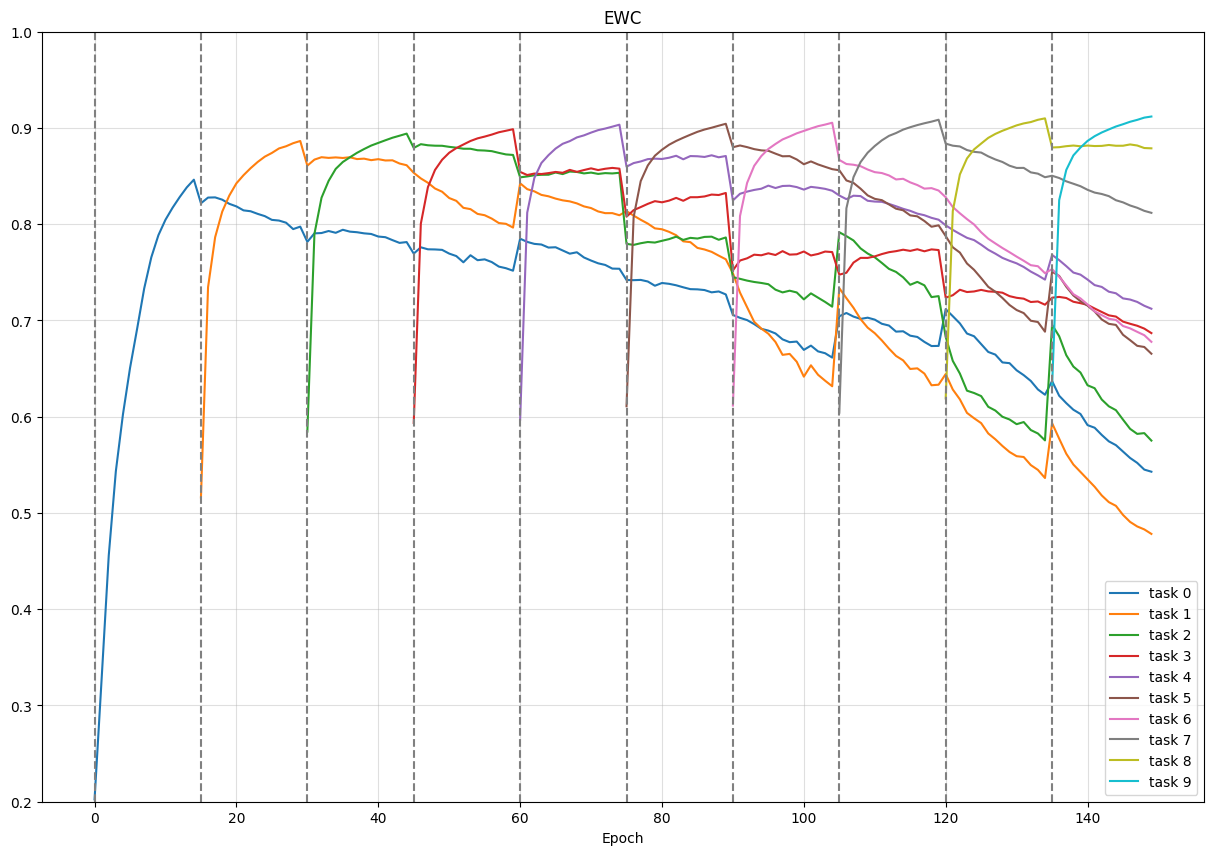

In [29]:
n_tasks, total_epochs = metrics_perm["ewc"]["train_accuracies"].shape
# fig, axes = plt.subplots(n_tasks, 1, figsize=(10, 8), sharex=True)
plt.figure(figsize=(15, 10))
plt.title("EWC")
for i in range(n_tasks):
  valid_epochs_ewc = np.where(metrics_perm["ewc"]["train_accuracies"][i]  > 0)[0]
  plt.plot(valid_epochs_ewc, metrics_perm["ewc"]["train_accuracies"][i, valid_epochs_ewc], label=f"task {i}")
plt.vlines(np.arange(0, total_epochs -2, num_epochs), 0.2, 1.0, linestyles="--", colors="gray")
plt.legend(loc="lower right", fontsize=10)
plt.ylim(0.2, 1.0)
plt.grid(alpha=0.4)


plt.xlabel("Epoch")
plt.savefig("10_tasks_EWC_perm", dpi=300)
# fig.suptitle("Accuracy for permutedMNIST", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])

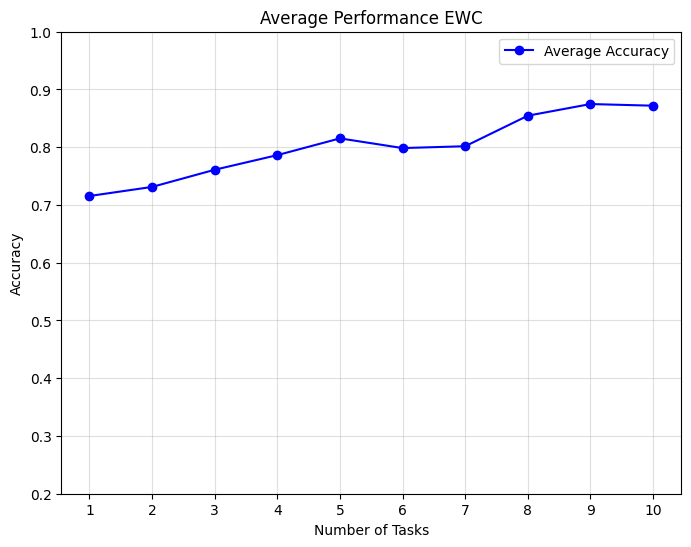

In [30]:
# Compute average accuracy per task
avg_accuracies = [
    np.mean(metrics_perm["ewc"]["train_accuracies"][i][metrics_perm["ewc"]["train_accuracies"][i] > 0])
    for i in range(n_tasks)
]

# X-axis: Number of tasks (1 to 10)
task_numbers = np.arange(1, n_tasks + 1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(task_numbers, avg_accuracies, marker='o', linestyle='-', color='b', label="Average Accuracy")

plt.xlabel("Number of Tasks")
plt.ylabel("Accuracy")
plt.title("Average Performance EWC")
plt.xticks(task_numbers)  # Ensure x-axis labels are integer task numbers
plt.ylim(0.2, 1.0)
plt.grid(alpha=0.4)
plt.legend()
plt.savefig("Average_Performance_EWC_perm.png", dpi=300)
plt.show()
